> Этот демонстрационный ноутбук использует импорт из модуля utils, поэтому для его запуска необходимо, чтобы он находился в одной директории с ним

In [1]:
from utils import transform, color_blurring, illumination

# Трансформация в единый тон

Функция `transform()` преобразует изображение таким образом, что при переводе в режим оттенков серого каждый его пиксель окрашивается в один и тот же цвет. 

> В режиме оттенков серого у каждого пикселя есть только один канал со значениями от 0 (черный) до 255 (белый). А как понять, какой цвет является темным, а какой светлым? Чтобы корректно преобразовать цветное изображение в режим оттенков серого? Для этого из трех каналов RGB вычисляют среднее взвешенное, в котором каждому каналу назначается свой вес в соответствии с тем, как человеческий глаз воспринимает те или иные цвета. [Обычно](https://ru.wikipedia.org/wiki/%D0%9E%D1%82%D1%82%D0%B5%D0%BD%D0%BA%D0%B8_%D1%81%D0%B5%D1%80%D0%BE%D0%B3%D0%BE#:~:text=%D0%94%D0%BB%D1%8F%20%D1%83%D1%87%D1%91%D1%82%D0%B0%20%D0%BE%D1%81%D0%BE%D0%B1%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9%20%D0%B2%D0%BE%D1%81%D0%BF%D1%80%D0%B8%D1%8F%D1%82%D0%B8%D1%8F%20%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%BC%20%D0%B3%D0%BB%D0%B0%D0%B7%D0%BE%D0%BC) используют следующую формулу:
> 
> $C = 0.2126R + 0.7152G + 0.0722B$
> 
> Таким образом, например, все цвета, которые при переводе в оттенки серого дают значение 100, являются примерно равными по уровню яркости. Подытоживая все вышесказанное, функция `transform()` способна "выровнять" цвета изображения под один уровень яркости.

Аргументы функции:
- **image_name** - имя файла изображения, лежащего в папке `input/`;
- **target** - цель преобразования (значение цвета в режиме оттенков серого) по шкале от 0 до 1. Можно также указать имя файла изображения из папки `input/`, которое будет наложено на исходную картинку, и тогда у каждого пикселя будет своя собственная цель;
- **output_name** - имя файла для сохранения. Если не указать расширение, по умолчанию будет использоваться *.png*. Если указать *None*, результат сохраняться не будет;
- **grayscale** - коэффициенты RGB для преобразования в режим оттенков серого. По умолчанию используются общепризнанные значения (0.2126, 0.7152, 0.0722). В пространстве цветов задают плоскость $ψ: 0.2126R + 0.7152G + 0.0722B = target$ (или с другими пользовательскими значениями коэффициентов **grayscale**). Таким образом, любой цвет, принадлежащий плоскости $ψ$, в процессе преобразования в оттенки серого трансформируется в точности в **target**;
- **fast_mode** - при значении True используется быстрый режим, при False - стандартный. Быстрый режим использует неточный алгоритм поиска ближайшего цвета, принадлежащего плоскости $ψ$, поэтому получаемые с его помощью цвета не всегда являются наиболее близкими к исходным, зато его скорость примерно в 2 раза выше, чем у стандартного алгоритма. По умолчанию быстрый режим *выключен*;
- **test_mode** - флаг тестового режима, при котором результат преобразования никуда не сохраняется, а исходное изображение уменьшается для ускорения работы алгоритма. Тестовый режим имеет смысл применять для проверки разных значений параметров перед основным преобразованием картинки. По умолчанию режим выключен (значение *False*). Если указать *True*, исходная картинка будет уменьшена до разрешения 100, но можно указать и свое собственное разрешение в качестве значения этого параметра.

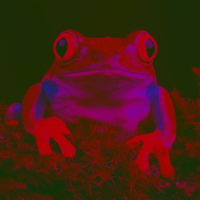

In [2]:
transform('images/frog.png', 
          target=0.15,
          test_mode=200)

# Цветовое размытие

Функция `color_blurring()` размывает цвета изображения, создавая эффект свечения.

> Для создания этого эффекта вызывается функция `transform()`, в которую в качестве изображения передается размытая по Гауссу версия исходной картинки, а в качестве цели (*target*) передается сама исходная картинка.

Аргументы функции:
- **image_name** - имя файла изображения, лежащего в папке `input/`;
- **blur_factor** - степень размытия по шкале от 0 до 1;
- **output_name**, **grayscale**, **fast_mode**, **test_mode** - аргументы функции `transform()`.

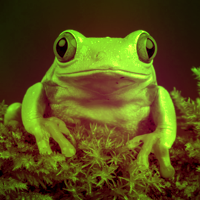

In [3]:
color_blurring('images/frog.png', 
               blur_factor=0.3,
               test_mode=200)

# Цветное освещение

Функция `illumination()` имитирует цветное освещение (но делает это местами криво).

> Для создания этого эффекта вызывается функция `transform()`, в которую передаются такие коэффициенты grayscale, которые заставляют все цвета исходного изображения изменяться в таком пространственном направлении, при котром переданный цвет меняться не будет. Например, если указать цвет (255, 0, 0), то есть красный, то красный канал вообще не будет участвовать в преобразовании, а вот остальные каналы будут корректироваться. Параметр intensity при этом задает степень учета всех остальных (изменяемых) цветов. Чем ниже этот показатель, тем в более низкие (темные) значения будут преобразованы цвета кроме цвета освещения. Подытоживая все вышеперечисленное, функция `illumination()` с низким значением intensity уменьшает влияние всех цветов кроме указанного. С большим значением intensity влияние всех остальных цветов усиливается.

Аргументы функции:
- **image_name** - имя файла изображения, лежащего в папке `input/`;
- **intensity** - степень учета изменяемых цветов от 0 до 1;
- **color** - цвет освещения в формате \[R, G, B\], каждое значение от 0 до 255;
- **output_name**, **grayscale**, **fast_mode**, **test_mode** - аргументы функции `transform()`.

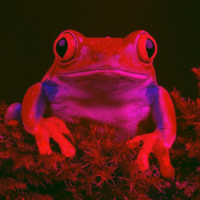

In [4]:
illumination('images/frog.png', 
             color=[255, 0, 255],
             intensity=0.1,
             test_mode=200)